In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Exploratory data analysis (EDA)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# Load the dataset

DATASET_COLUMNS=['Description','Label']
data = pd.read_excel('/content/drive/MyDrive/Projects/Bangla_Sentiment_Analysis/bangla_data.xlsx', names=DATASET_COLUMNS)

In [5]:
# General overview of the data
data_info = data.info()
data_description = data.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3002 entries, 0 to 3001
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Description  3002 non-null   object
 1   Label        3002 non-null   object
dtypes: object(2)
memory usage: 47.0+ KB


In [6]:
# Checking for missing values
missing_values = data.isnull().sum()
missing_values

,0
Description,0
Label,0


In [7]:
# Analyzing the distribution of categories
category_distribution = data['Description'].value_counts()
category_distribution

,count
Description,
"মানুষ আমাকে সবসময় স্বার্থের জন্য ব্যবহার করে, ভালোবাসার জন্যে নয়।",3
ঠিক না থাকা ঠিক আছে।,3
যে তোমাকে ভালোবাসে সে কখনো তোমার হট পিক চাইবে না বরং তোমাকে পর্দা করতে বলবে।,2
আপনি এই একা হয় না।,2
জানি সে আমার নয় তবু তাকে হারানোর ভয়।,2
...,...
গিরগিটি রং বদলায় আত্ম রক্ষার্থে। আর মানুষ রং বদলায় স্বার্থ রক্ষার্থে।,1
অভিজ্ঞ তোই আর অনভিজ্ঞ আমি। তাই তো আমাদের এতো তফাৎ।,1
ভালবাসা হলো এমন একটি মায়া তুমি যত দুরে যাবে যাবে ততই কাছে টানবে যত ভুলে যাবে ততই মনে পড়বে আর যতটুকু হাসবে তার থেকে বেশি কাঁদবে।,1


In [8]:
# Most common categories
category_distribution = data['Label'].value_counts()

print("Category Distribution:")
print(category_distribution)

Category Distribution:
Label
Non Depressive    1503
Depressive        1499
Name: count, dtype: int64


In [9]:
# Calculate word count for each article
data['content_length'] = data['Description'].apply(lambda x: len(str(x).split()))

# Calculate the average length
average_length = data['content_length'].mean()
print(f"Average article length: {average_length:.2f} words")

Average article length: 13.36 words


In [10]:
# Average content length per category
avg_length_per_category = data.groupby('Label')['content_length'].mean()

print("Average Article Length by Category:")
print(avg_length_per_category)


Average Article Length by Category:
Label
Depressive        13.682455
Non Depressive    13.035263
Name: content_length, dtype: float64


# Model Train

In [11]:
!pip install datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [12]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [13]:
# Load the dataset

DATASET_COLUMNS=['Description','Label']
df = pd.read_excel('/content/drive/MyDrive/Projects/Bangla_Sentiment_Analysis/bangla_data.xlsx', names=DATASET_COLUMNS)

In [14]:
df

,Description,Label
0,মানুষ একা থাকতে ভালোবাসে না। কিন্তু যখন তার দু...,Depressive
1,নিজের দুঃখ কখনো অন্যের কাছে প্রকাশ করতে নেই। স...,Depressive
2,"জল যেমন অনেক ঠান্ডা হতে হতে একসময় বরফ হয়ে যায়,...",Depressive
3,"কারো অবহেলিত ভালোবাসার চাইতে, জীবনে একা থাকা অ...",Depressive
4,"মাঝে মাঝে মনে হয় তুমি শুরুতেই যদি বলতে, আমার ম...",Depressive
...,...,...
2997,সাধারণ মানুষের করের টাকায় বেতন পাওয়া লোকেরা এগ...,Non Depressive
2998,১৯৭৪ সালে ঢাকা বিশ্ববিদ্যালয় ৭ খুনের মধ্যে দিয়...,Non Depressive
2999,আমি ভারতের নদীয়া বাসিন্দা আমার ফার্স্ট দেখা না...,Non Depressive
3000,মানবিকতা নয় পাশবিকতাই জয়ী যাদের কাছে গরুর জীবন...,Non Depressive


In [15]:
# Step 5: Split into Training and Validation Sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['Description'].tolist(),
    df['Label'].tolist(),
    test_size=0.2,
    random_state=42
)

In [16]:
# Step 6: Encode Labels
label_to_id = {label: idx for idx, label in enumerate(set(train_labels))}
id_to_label = {idx: label for label, idx in label_to_id.items()}

In [17]:
train_labels_enc = [label_to_id[label] for label in train_labels]
val_labels_enc = [label_to_id[label] for label in val_labels]

In [18]:
print(label_to_id)

{'Depressive': 0, 'Non Depressive': 1}


In [19]:
import os
os.environ["WANDB_MODE"] = "disabled"  # Disable Weights & Biases logging

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Step 7: Tokenize the Data
model_name = "bert-base-multilingual-cased"  # Multilingual BERT model
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)

In [ ]:
# Step 8: Create PyTorch Dataset Class
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

In [ ]:
# Create Dataset Objects
train_dataset = NewsDataset(train_encodings, train_labels_enc)
val_dataset = NewsDataset(val_encodings, val_labels_enc)

In [ ]:

# Step 9: Load Pretrained Model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=len(label_to_id)
).to(device)



model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Step 10: Define Metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
# Step 11: Set Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_total_limit=1,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Step 12: Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [ ]:
# Step 13: Train the Model
trainer.train()

A ConfigError was raised whilst setting the number of model parameters in Weights & Biases config.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.237300,0.233912,0.936772,0.936765,0.936779,0.936772


TrainOutput(global_step=301, training_loss=0.3753238759897773, metrics={'train_runtime': 252.565, 'train_samples_per_second': 9.506, 'train_steps_per_second': 1.192, 'total_flos': 567569601958800.0, 'train_loss': 0.3753238759897773, 'epoch': 1.0})

In [ ]:
# Step 14: Evaluate the Model
results = trainer.evaluate()
print(results)

{'eval_loss': 0.23391208052635193, 'eval_accuracy': 0.9367720465890182, 'eval_f1': 0.9367653880638281, 'eval_precision': 0.9367794998873704, 'eval_recall': 0.9367720465890182, 'eval_runtime': 18.0792, 'eval_samples_per_second': 33.243, 'eval_steps_per_second': 4.204, 'epoch': 1.0}


In [ ]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [ ]:
text = "জল যেমন অনেক ঠান্ডা হতে হতে একসময় বরফ হয়ে যায়, ঠিক তেমনি একটা মন অনেক কষ্ট পেতে পেতে এক সময় পাথর হয়ে যায়।"
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
predicted_class = torch.argmax(logits, dim=1).item()

id_to_label = {0: "Non Depressive", 1: "Depressive"}
print(f"Predicted Class: {id_to_label[predicted_class]}")

Predicted Class: Depressive


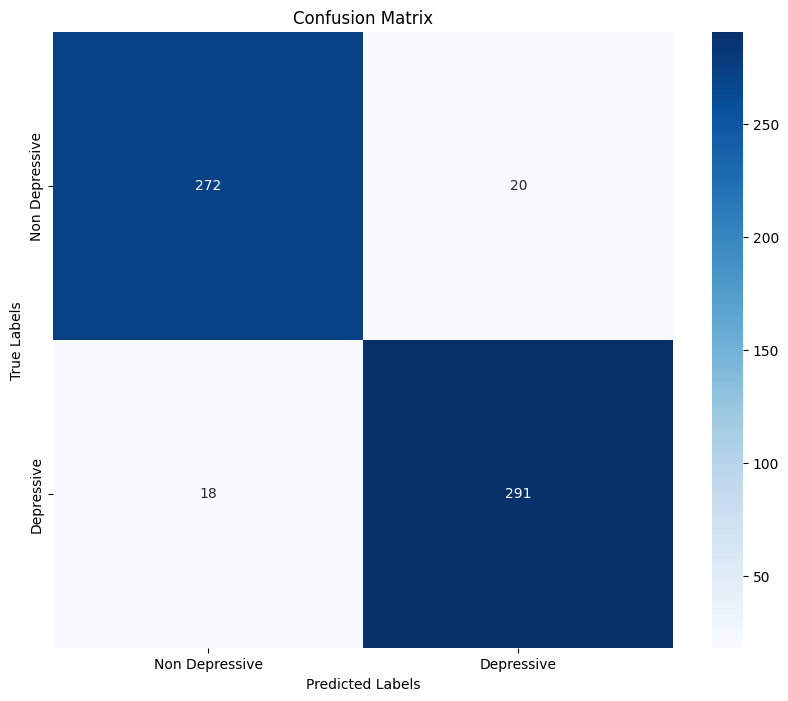

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

predictions = trainer.predict(val_dataset)

pred_labels = predictions.predictions.argmax(-1)
true_labels = predictions.label_ids

conf_matrix = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=[id_to_label[i] for i in range(len(id_to_label))],
            yticklabels=[id_to_label[i] for i in range(len(id_to_label))])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# prompt: Generate classification report for this bangla bert model based on the previous cells

from sklearn.metrics import classification_report

predictions = trainer.predict(val_dataset)
pred_labels = predictions.predictions.argmax(-1)
true_labels = predictions.label_ids

print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       292
           1       0.94      0.94      0.94       309

    accuracy                           0.94       601
   macro avg       0.94      0.94      0.94       601
weighted avg       0.94      0.94      0.94       601



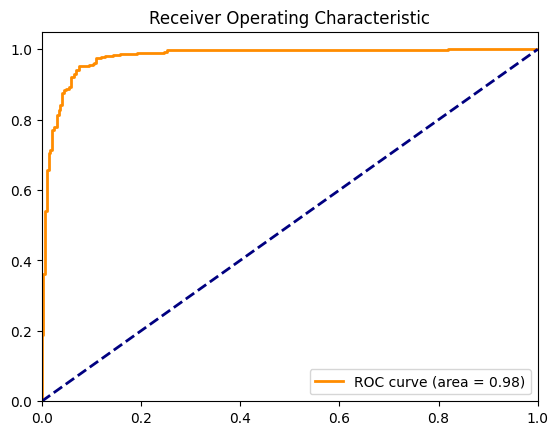

In [ ]:
# prompt: draw a roc curve

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming 'predictions' contains predicted probabilities for the positive class
# and 'true_labels' are the actual labels (0 or 1)
fpr, tpr, thresholds = roc_curve(true_labels, predictions.predictions[:, 1]) # Assuming binary classification
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])


plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Bangla-BERT

In [21]:
# Step 7: Tokenize the Data
model_name = "csebuetnlp/banglabert"
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/528k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [22]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)

In [23]:
# Step 8: Create PyTorch Dataset Class
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

In [24]:
# Create Dataset Objects
train_dataset = NewsDataset(train_encodings, train_labels_enc)
val_dataset = NewsDataset(val_encodings, val_labels_enc)

In [25]:

# Step 9: Load Pretrained Model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=len(label_to_id)
).to(device)



pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
# Step 10: Define Metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [27]:
# Step 11: Set Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_total_limit=1,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [28]:
# Step 12: Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [29]:
# Step 13: Train the Model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.085500,0.164398,0.955075,0.955054,0.955293,0.955075


TrainOutput(global_step=301, training_loss=0.22391163613461576, metrics={'train_runtime': 162.1475, 'train_samples_per_second': 14.808, 'train_steps_per_second': 1.856, 'total_flos': 396064874410380.0, 'train_loss': 0.22391163613461576, 'epoch': 1.0})

In [30]:
# Step 14: Evaluate the Model
results = trainer.evaluate()
print(results)

{'eval_loss': 0.16439814865589142, 'eval_accuracy': 0.9550748752079867, 'eval_f1': 0.95505394648434, 'eval_precision': 0.9552927924182916, 'eval_recall': 0.9550748752079867, 'eval_runtime': 10.9047, 'eval_samples_per_second': 55.114, 'eval_steps_per_second': 6.969, 'epoch': 1.0}


In [31]:
print(model)

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [54]:
text = "জীবনের ছোট ছোট মুহূর্তগুলোই সবচেয়ে বড় সুখ এনে দেয়।"
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
predicted_class = torch.argmax(logits, dim=1).item()

id_to_label = {1: "Non Depressive", 0: "Depressive"}
print(f"Predicted Class: {id_to_label[predicted_class]}")

Predicted Class: Depressive


**Confusion Matrix Bangla Bert**

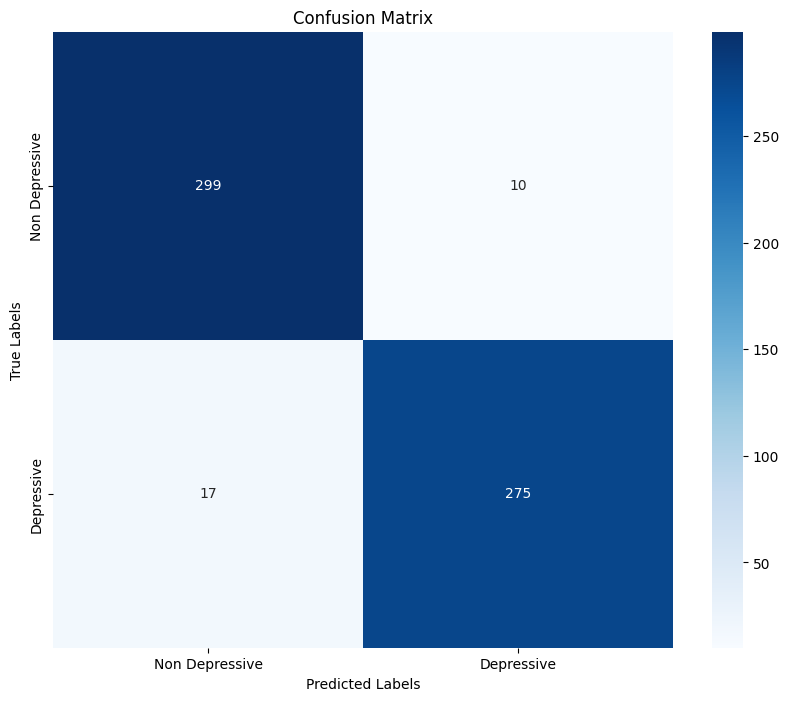

In [33]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

predictions = trainer.predict(val_dataset)

pred_labels = predictions.predictions.argmax(-1)
true_labels = predictions.label_ids

conf_matrix = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=[id_to_label[i] for i in range(len(id_to_label))],
            yticklabels=[id_to_label[i] for i in range(len(id_to_label))])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [34]:
# prompt: Generate classification report for this bangla bert model based on the previous cells

from sklearn.metrics import classification_report

predictions = trainer.predict(val_dataset)
pred_labels = predictions.predictions.argmax(-1)
true_labels = predictions.label_ids

print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       309
           1       0.96      0.94      0.95       292

    accuracy                           0.96       601
   macro avg       0.96      0.95      0.96       601
weighted avg       0.96      0.96      0.96       601



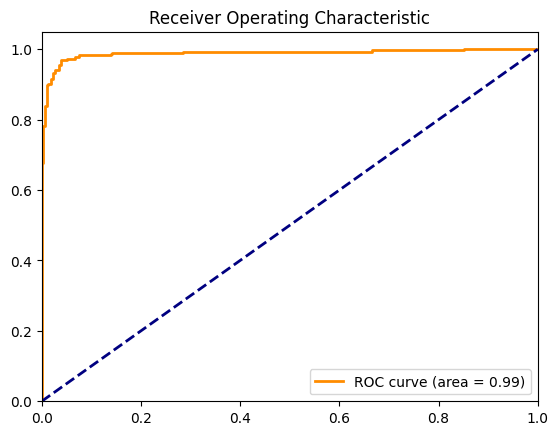

In [35]:
# prompt: genrate a roc curve for trainning accuracy based on the classification report

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming 'predictions' contains predicted probabilities for the positive class
# and 'true_labels' are the actual labels (0 or 1)
fpr, tpr, thresholds = roc_curve(true_labels, predictions.predictions[:, 1]) # Assuming binary classification
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])


plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [36]:
# prompt: genererate accuracy for this model

from sklearn.metrics import accuracy_score

# ... (Your existing code) ...

# Assuming 'predictions' contains predicted probabilities for the positive class
# and 'true_labels' are the actual labels (0 or 1)
predictions = trainer.predict(val_dataset)
pred_labels = predictions.predictions.argmax(-1)
true_labels = predictions.label_ids

accuracy = accuracy_score(true_labels, pred_labels)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9550748752079867


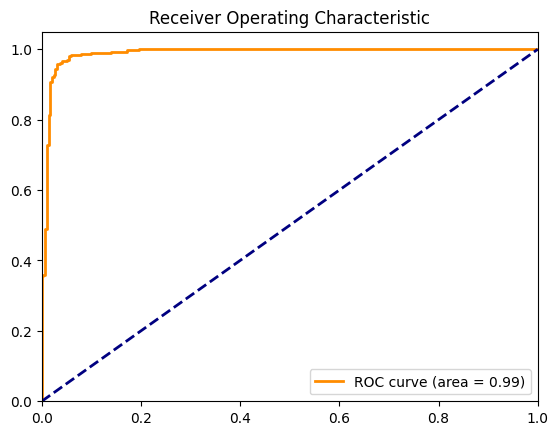

In [ ]:
# prompt: draw a roc curve

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming 'predictions' contains predicted probabilities for the positive class
# and 'true_labels' are the actual labels (0 or 1)
fpr, tpr, thresholds = roc_curve(true_labels, predictions.predictions[:, 1]) # Assuming binary classification
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])


plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [58]:
!pip install python-bidi
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from bidi.algorithm import get_display



bidi_text = get_display(df['Label'])
print(bidi_text)
# https://github.com/amueller/word_cloud/issues/367
# https://stackoverflow.com/questions/54063438/create-wordcloud-in-python-for-foreign-language-hebrew
# https://www.omicronlab.com/bangla-fonts.html
rgx = r"[\u0980-\u09FF]+"
wordcloud = WordCloud(font_path='/content/Siyamrupali.ttf',
regexp=rgx).generate(bidi_text)

#wordcloud = WordCloud(font_path='/content/FreeSansBold.ttf').generate(bidi_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 16.1 MB/s eta 0:00:00


TypeError: bidirectional() argument must be a unicode character, not str

Distil Bert

In [ ]:
# Step 7: Tokenize the Data
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)

In [ ]:
# Step 8: Create PyTorch Dataset Class
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

In [ ]:
# Create Dataset Objects
train_dataset = NewsDataset(train_encodings, train_labels_enc)
val_dataset = NewsDataset(val_encodings, val_labels_enc)

In [ ]:

# Step 9: Load Pretrained Model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=len(label_to_id)
).to(device)



model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Step 10: Define Metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
# Step 11: Set Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_total_limit=1,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Step 12: Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [ ]:
# Step 13: Train the Model
trainer.train()

A ConfigError was raised whilst setting the number of model parameters in Weights & Biases config.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.384000,0.453646,0.810316,0.810285,0.812050,0.810316


TrainOutput(global_step=301, training_loss=0.524119341690279, metrics={'train_runtime': 127.6229, 'train_samples_per_second': 18.813, 'train_steps_per_second': 2.359, 'total_flos': 318054224173056.0, 'train_loss': 0.524119341690279, 'epoch': 1.0})

In [ ]:
# Step 14: Evaluate the Model
results = trainer.evaluate()
print(results)

{'eval_loss': 0.4536464810371399, 'eval_accuracy': 0.8103161397670549, 'eval_f1': 0.8102846301222842, 'eval_precision': 0.8120503771034316, 'eval_recall': 0.8103161397670549, 'eval_runtime': 8.8369, 'eval_samples_per_second': 68.011, 'eval_steps_per_second': 8.6, 'epoch': 1.0}


In [ ]:
print(model)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
text = "জল যেমন অনেক ঠান্ডা হতে হতে একসময় বরফ হয়ে যায়, ঠিক তেমনি একটা মন অনেক কষ্ট পেতে পেতে এক সময় পাথর হয়ে যায়।"
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
predicted_class = torch.argmax(logits, dim=1).item()

id_to_label = {0: "Non Depressive", 0: "Depressive"}
print(f"Predicted Class: {id_to_label[predicted_class]}")

Predicted Class: Depressive


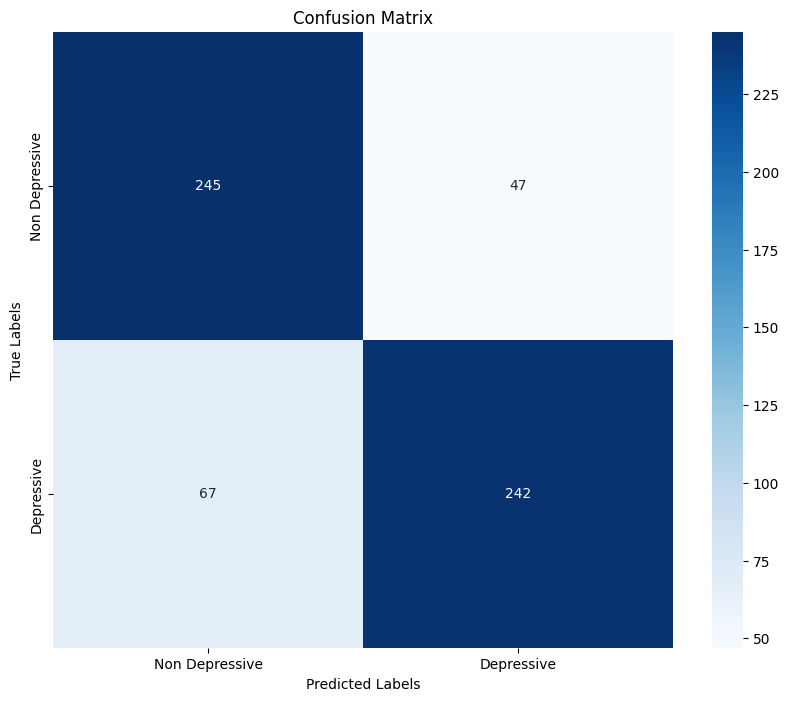

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

predictions = trainer.predict(val_dataset)

pred_labels = predictions.predictions.argmax(-1)
true_labels = predictions.label_ids

conf_matrix = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=[id_to_label[i] for i in range(len(id_to_label))],
            yticklabels=[id_to_label[i] for i in range(len(id_to_label))])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# prompt: Generate classification report for this bangla bert model based on the previous cells

from sklearn.metrics import classification_report

predictions = trainer.predict(val_dataset)
pred_labels = predictions.predictions.argmax(-1)
true_labels = predictions.label_ids

print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.79      0.84      0.81       292
           1       0.84      0.78      0.81       309

    accuracy                           0.81       601
   macro avg       0.81      0.81      0.81       601
weighted avg       0.81      0.81      0.81       601



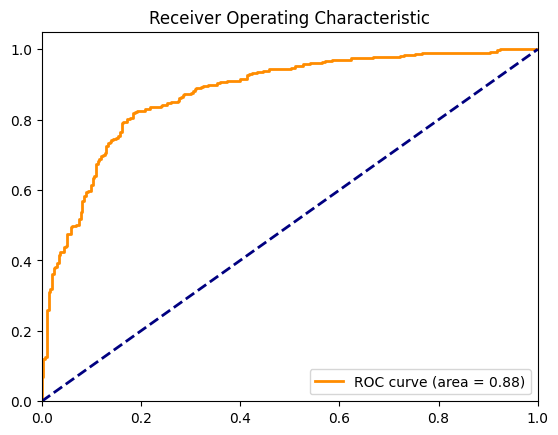

In [ ]:
# prompt: draw a roc curve

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming 'predictions' contains predicted probabilities for the positive class
# and 'true_labels' are the actual labels (0 or 1)
fpr, tpr, thresholds = roc_curve(true_labels, predictions.predictions[:, 1]) # Assuming binary classification
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])


plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

XLM-R

In [ ]:
# Step 7: Tokenize the Data
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)

In [ ]:
# Step 8: Create PyTorch Dataset Class
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

In [ ]:
# Create Dataset Objects
train_dataset = NewsDataset(train_encodings, train_labels_enc)
val_dataset = NewsDataset(val_encodings, val_labels_enc)

In [ ]:

# Step 9: Load Pretrained Model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=len(label_to_id)
).to(device)



model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Step 10: Define Metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
# Step 11: Set Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_total_limit=1,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Step 12: Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [ ]:
# Step 13: Train the Model
trainer.train()

A ConfigError was raised whilst setting the number of model parameters in Weights & Biases config.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.260100,0.317041,0.935108,0.934964,0.937124,0.935108


TrainOutput(global_step=301, training_loss=0.35240618396005857, metrics={'train_runtime': 203.4249, 'train_samples_per_second': 11.803, 'train_steps_per_second': 1.48, 'total_flos': 414572578822080.0, 'train_loss': 0.35240618396005857, 'epoch': 1.0})

In [ ]:
# Step 14: Evaluate the Model
results = trainer.evaluate()
print(results)

{'eval_loss': 0.31704065203666687, 'eval_accuracy': 0.9351081530782029, 'eval_f1': 0.9349642123241841, 'eval_precision': 0.9371242494757424, 'eval_recall': 0.9351081530782029, 'eval_runtime': 12.4721, 'eval_samples_per_second': 48.188, 'eval_steps_per_second': 6.094, 'epoch': 1.0}


In [ ]:
print(model)

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

In [ ]:
text = "জল যেমন অনেক ঠান্ডা হতে হতে একসময় বরফ হয়ে যায়, ঠিক তেমনি একটা মন অনেক কষ্ট পেতে পেতে এক সময় পাথর হয়ে যায়।"
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
predicted_class = torch.argmax(logits, dim=1).item()

id_to_label = {0: "Non Depressive", 1: "Depressive"}
print(f"Predicted Class: {id_to_label[predicted_class]}")

Predicted Class: Depressive


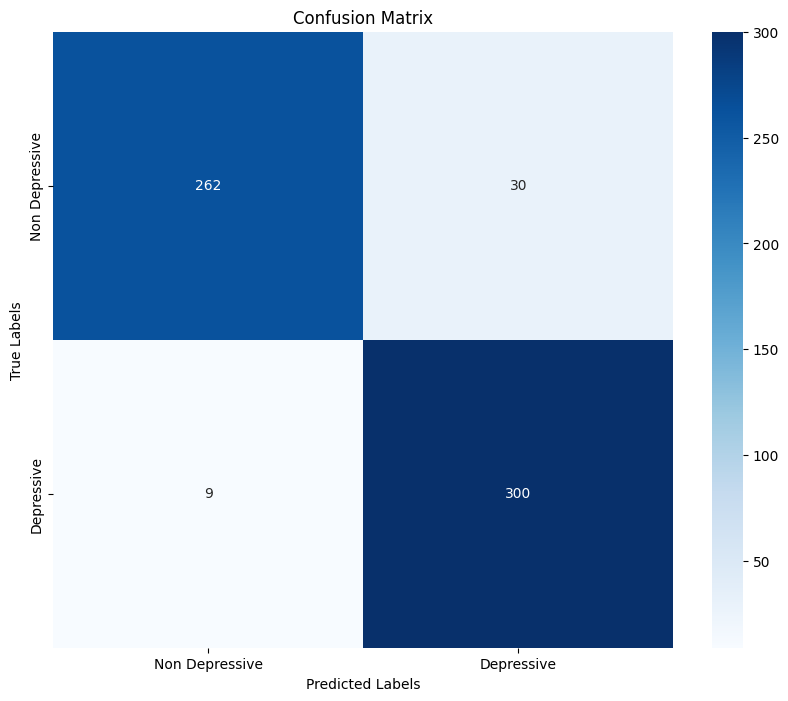

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

predictions = trainer.predict(val_dataset)

pred_labels = predictions.predictions.argmax(-1)
true_labels = predictions.label_ids

conf_matrix = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=[id_to_label[i] for i in range(len(id_to_label))],
            yticklabels=[id_to_label[i] for i in range(len(id_to_label))])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# prompt: Generate classification report for this bangla bert model based on the previous cells

from sklearn.metrics import classification_report

predictions = trainer.predict(val_dataset)
pred_labels = predictions.predictions.argmax(-1)
true_labels = predictions.label_ids

print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.97      0.90      0.93       292
           1       0.91      0.97      0.94       309

    accuracy                           0.94       601
   macro avg       0.94      0.93      0.93       601
weighted avg       0.94      0.94      0.93       601



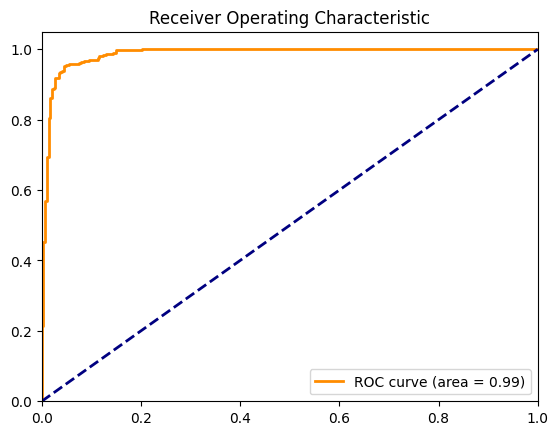

In [ ]:
# prompt: draw a roc curve

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming 'predictions' contains predicted probabilities for the positive class
# and 'true_labels' are the actual labels (0 or 1)
fpr, tpr, thresholds = roc_curve(true_labels, predictions.predictions[:, 1]) # Assuming binary classification
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])


plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

indic-bert

In [ ]:
# Step 7: Tokenize the Data
model_name = "ai4bharat/indic-bert"
tokenizer = AutoTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)

In [ ]:
# Step 8: Create PyTorch Dataset Class
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

In [ ]:
# Create Dataset Objects
train_dataset = NewsDataset(train_encodings, train_labels_enc)
val_dataset = NewsDataset(val_encodings, val_labels_enc)

In [ ]:

# Step 9: Load Pretrained Model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=len(label_to_id)
).to(device)



pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Step 10: Define Metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
# Step 11: Set Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_total_limit=1,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Step 12: Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [ ]:
# Step 13: Train the Model
trainer.train()

A ConfigError was raised whilst setting the number of model parameters in Weights & Biases config.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.525300,0.415194,0.848586,0.848570,0.850252,0.848586


TrainOutput(global_step=301, training_loss=0.5536969659534403, metrics={'train_runtime': 172.9415, 'train_samples_per_second': 13.883, 'train_steps_per_second': 1.74, 'total_flos': 42698299660380.0, 'train_loss': 0.5536969659534403, 'epoch': 1.0})

In [ ]:
# Step 14: Evaluate the Model
results = trainer.evaluate()
print(results)

{'eval_loss': 0.4151943027973175, 'eval_accuracy': 0.848585690515807, 'eval_f1': 0.8485697608603547, 'eval_precision': 0.8502520930577506, 'eval_recall': 0.848585690515807, 'eval_runtime': 12.05, 'eval_samples_per_second': 49.876, 'eval_steps_per_second': 6.307, 'epoch': 1.0}


In [ ]:
print(model)

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(200000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertSdpaAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features

In [ ]:
text = "জল যেমন অনেক ঠান্ডা হতে হতে একসময় বরফ হয়ে যায়, ঠিক তেমনি একটা মন অনেক কষ্ট পেতে পেতে এক সময় পাথর হয়ে যায়।"
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
predicted_class = torch.argmax(logits, dim=1).item()

id_to_label = {0: "Non Depressive", 1: "Depressive"}
print(f"Predicted Class: {id_to_label[predicted_class]}")

Predicted Class: Depressive


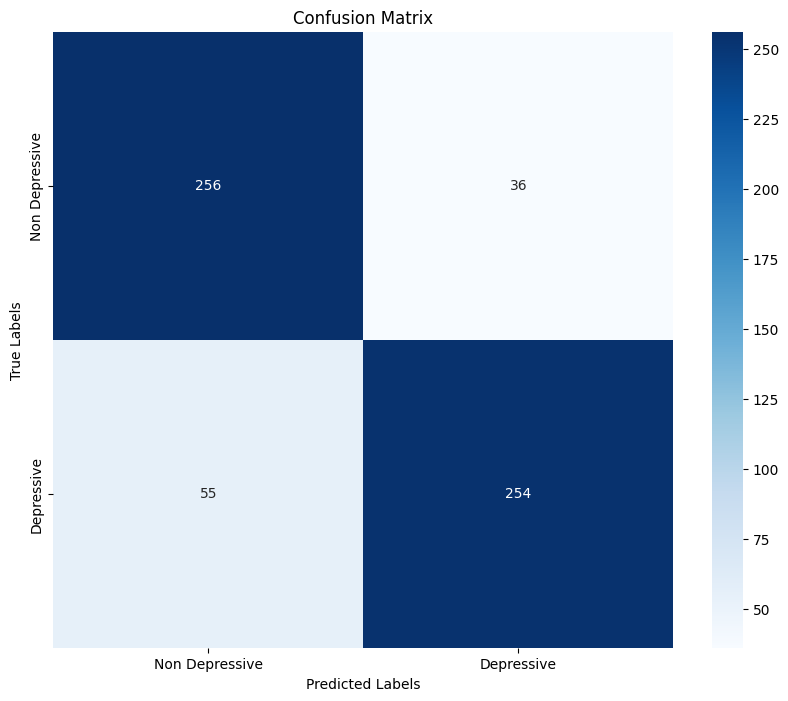

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

predictions = trainer.predict(val_dataset)

pred_labels = predictions.predictions.argmax(-1)
true_labels = predictions.label_ids

conf_matrix = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=[id_to_label[i] for i in range(len(id_to_label))],
            yticklabels=[id_to_label[i] for i in range(len(id_to_label))])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# prompt: Generate classification report for this bangla bert model based on the previous cells

from sklearn.metrics import classification_report

predictions = trainer.predict(val_dataset)
pred_labels = predictions.predictions.argmax(-1)
true_labels = predictions.label_ids

print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       292
           1       0.88      0.82      0.85       309

    accuracy                           0.85       601
   macro avg       0.85      0.85      0.85       601
weighted avg       0.85      0.85      0.85       601



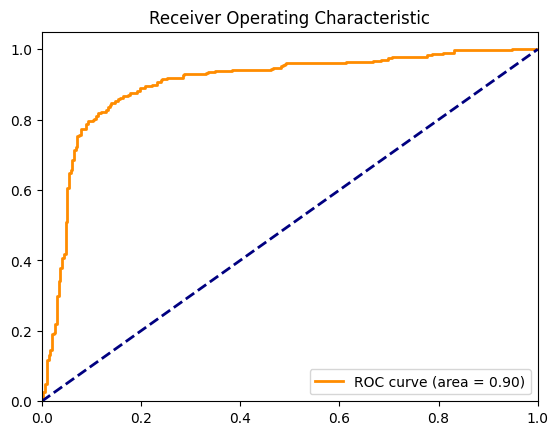

In [ ]:
# prompt: draw a roc curve

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming 'predictions' contains predicted probabilities for the positive class
# and 'true_labels' are the actual labels (0 or 1)
fpr, tpr, thresholds = roc_curve(true_labels, predictions.predictions[:, 1]) # Assuming binary classification
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])


plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()